In [93]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp
import utils.scipy_fitting as sf


from utils.models_catalogue import lv_model_2pop_derivatives_basic

Parameters to adjust for the simulation

In [94]:
nb_years = 3
study_case_name = "réaliste" # "parfait", "bruité", "réaliste"
hol_func = "holling2" # "holling1", "holling2", "holling3", "holling1_sat"




# ------ Data generation parameters ------
# common_sample_plan_unif = True # False if we want uniform sampling for predator and batch for prey
# nb_points_predator = 200
# nb_points_prey = 200 # NB: nb_points_prey=nb_points_predator if common_sample_plan_unif = True
# ratio_in_out_batch = 1/2 # here sampling data for prey will occur only on 1/2 of the year 
# data_noise_intensity = 0
# noise_seed = 111

if study_case_name == "parfait":
    common_sample_plan_unif = True # False if we want uniform sampling for predator and batch for prey
    nb_points_predator = 200
    nb_points_prey = 200 # NB: nb_points_prey=nb_points_predator if common_sample_plan_unif = True
    ratio_in_out_batch = 1
    data_noise_intensity = 0
    noise_seed = 111
elif study_case_name == "bruité":
    common_sample_plan_unif = True # False if we want uniform sampling for predator and batch for prey
    nb_points_predator = 200
    nb_points_prey = 200 # NB: nb_points_prey=nb_points_predator if common_sample_plan_unif = True
    ratio_in_out_batch = 1
    data_noise_intensity = 0.1
    noise_seed = 111
if study_case_name == "réaliste":
    common_sample_plan_unif = False # False if we want uniform sampling for predator and batch for prey
    nb_points_predator = 25
    nb_points_prey = 60
    ratio_in_out_batch = 1/3 # here sampling data for prey will occur only on 1/2 of the year 
    data_noise_intensity = 0.1
    noise_seed = 111


# ------ True parameters of the dynamics (depending on holling function) ------
if hol_func == "holling1":
    eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, 
                       "func_resp": "holling1", "a": 0.086} # b = e/S
elif hol_func == "holling1_sat":
    eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, 
                       "func_resp": "holling1_sat", "a": 0.086} # b = e/S
elif hol_func == "holling2":
    eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, 
                       "func_resp": "holling2", "a": 0.13} # b = e/S
elif hol_func == "holling3":
    eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, 
                       "func_resp": "holling3", "a": 1.6} # b = e/S


# ------ Initial guess of the parameters ------
# fitted_params = ['a1', 'a2', 'e', 'c', 'K', 'S', 'a']
fitted_params = ['a1', 'a2', 'c', 'K', 'S', 'a'] # e fixed
# fitted_params = ['a1', 'a2', 'K', 'a'] # Léo parameters
# fitted_params = ['a1', 'a2']

# noise_init_params = 0.05 # if you want to randomly initialize the parameters around the true values
# params_fitted_init = {key: value * (1+np.random.normal(0, noise_init_params)) \
#                       for key, value in eco_params_2pop.items() if key in fitted_params}
params_fitted_init = {key: value for key, value in \
                      {"a1": 0.1, "a2": 0.01, "e": 1, "c": 1, "K": 0.03, "S": 0.1, "a": 0.1}.items() if key in fitted_params}


# ------ Neural Network parameters ------
nn_architecture = [1, 128, 128, 128, 2]
lr = 1e-3
niter_weights=[50000]
weights = [[5, 5, 0.5, 0.5, 10, 10]] # [[PDE, BC, Data]]



t_max = 365 * nb_years
xR1, xR2 = 0.12, 0.91
X_ini = [xR1, xR2] # Predator, Prey

In [95]:
# Create a directory for outputs
directory_path = "outputs/LV2_study_case/" + eco_params_2pop["func_resp"] + '-' + study_case_name + '-' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# directory_path = "outputs/LV2_study_case/datagen/"
if not os.path.exists(directory_path): os.makedirs(directory_path) ; print(f"Directory created at: {directory_path}")
else: print(f"Directory already exists at: {directory_path}")
path_for_export = os.path.join(directory_path, 'out')
# path_for_export = os.path.join(directory_path, eco_params_2pop["func_resp"] + '_' + study_case_name)
print(f"Path for export: {path_for_export}")

Directory already exists at: outputs/LV2_study_case/datagen/
Path for export: outputs/LV2_study_case/datagen/holling2_réaliste


# Show the dynamics chosen
(Nothing to change in this section)

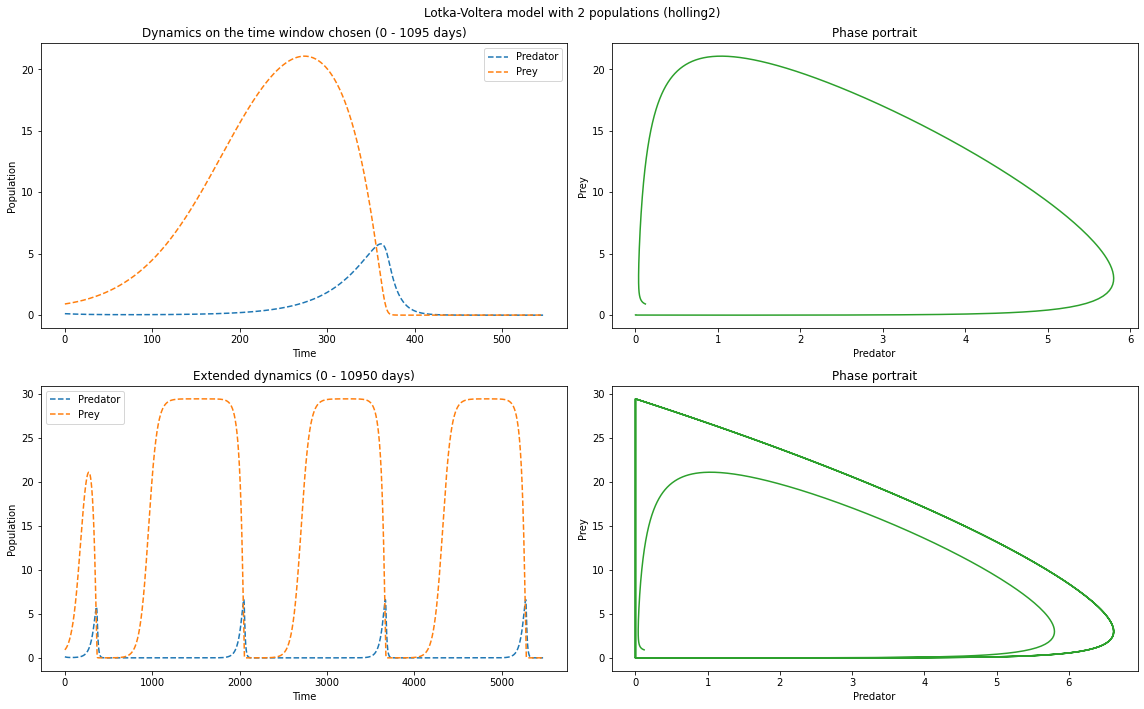

In [96]:
# Plot the dynamics
nb_pts_simu_init = 10000
t_simu = np.linspace(0, t_max*5, nb_pts_simu_init)
X_simu = odeint(lv_model_2pop_derivatives_basic, X_ini, t_simu, args=(eco_params_2pop, ), atol=1e-8, rtol=1e-11)

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
idx_max = 500
axs[0, 0].plot(t_simu[:nb_pts_simu_init//10], X_simu[:nb_pts_simu_init//10], '--')
axs[0, 0].set_xlabel("Time") ; axs[0, 0].set_ylabel("Population")
axs[0, 0].set_title("Dynamics on the time window chosen (0 - "+str(t_max)+" days)")
axs[0, 0].legend(["Predator", "Prey"])
axs[0, 1].plot(X_simu[:nb_pts_simu_init//10, 0], X_simu[:nb_pts_simu_init//10, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[0, 1].set_xlabel("Predator")
axs[0, 1].set_ylabel("Prey")
axs[0, 1].set_title("Phase portrait")
axs[1, 0].plot(t_simu, X_simu, '--')
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Population")
axs[1, 0].set_title("Extended dynamics (0 - "+str(t_max*10)+" days)")
axs[1, 0].legend(["Predator", "Prey"])
axs[1, 1].plot(X_simu[:, 0], X_simu[:, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[1, 1].set_xlabel("Predator")
axs[1, 1].set_ylabel("Prey")
axs[1, 1].set_title("Phase portrait")

plt.suptitle("Lotka-Voltera model with 2 populations ("+eco_params_2pop["func_resp"]+")")
plt.tight_layout()
plt.savefig(path_for_export + "-Data-1_dynamics_court.jpg")
plt.show()

C:\Users\Raph\AppData\Local\Temp\ipykernel_5444\3738079706.py:4: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  X_simu = odeint(lv_model_2pop_derivatives_basic, X_ini, t_simu, args=(eco_params_2pop, ), atol=1e-8, rtol=1e-11)


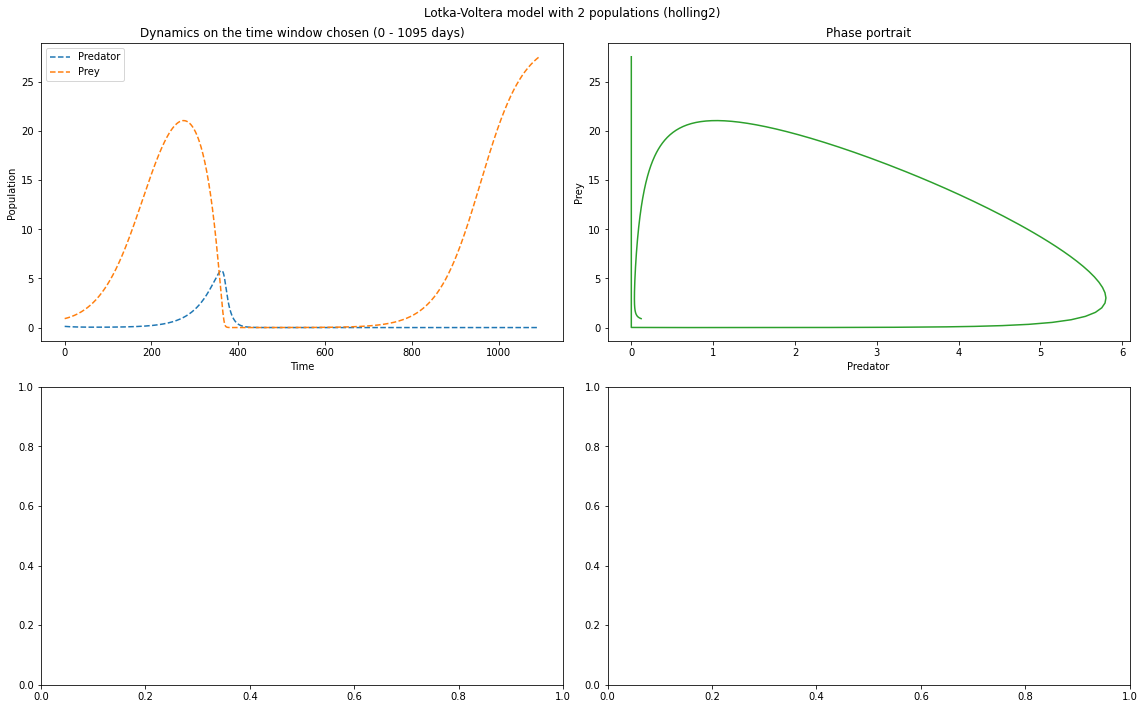

In [97]:
# Plot the dynamics
nb_pts_simu_init = 10000
t_simu = np.linspace(0, t_max*10, nb_pts_simu_init)
X_simu = odeint(lv_model_2pop_derivatives_basic, X_ini, t_simu, args=(eco_params_2pop, ), atol=1e-8, rtol=1e-11)

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
idx_max = 500
axs[0, 0].plot(t_simu[:nb_pts_simu_init//10], X_simu[:nb_pts_simu_init//10], '--')
axs[0, 0].set_xlabel("Time") ; axs[0, 0].set_ylabel("Population")
axs[0, 0].set_title("Dynamics on the time window chosen (0 - "+str(t_max)+" days)")
axs[0, 0].legend(["Predator", "Prey"])
axs[0, 1].plot(X_simu[:nb_pts_simu_init//10, 0], X_simu[:nb_pts_simu_init//10, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[0, 1].set_xlabel("Predator")
axs[0, 1].set_ylabel("Prey")
axs[0, 1].set_title("Phase portrait")
axs[1, 0].plot(t_simu, X_simu, '--')
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Population")
axs[1, 0].set_title("Extended dynamics (0 - "+str(t_max*10)+" days)")
axs[1, 0].legend(["Predator", "Prey"])
axs[1, 1].plot(X_simu[:, 0], X_simu[:, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[1, 1].set_xlabel("Predator")
axs[1, 1].set_ylabel("Prey")
axs[1, 1].set_title("Phase portrait")

plt.suptitle("Lotka-Voltera model with 2 populations ("+eco_params_2pop["func_resp"]+")")
plt.tight_layout()
plt.savefig(path_for_export + "-Data-1_dynamics.jpg")
plt.show()

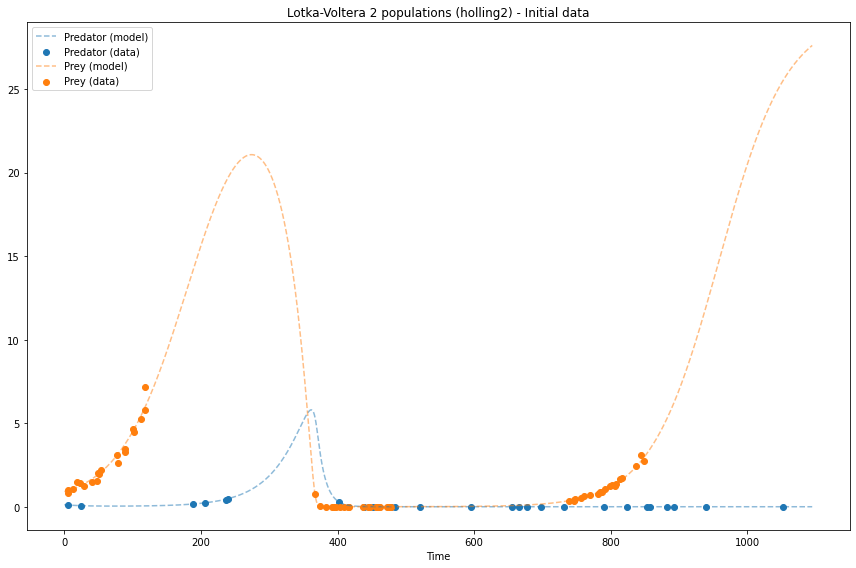

* * * * Sampled data * * * *
Number of points (predator-prey): 26 - 60
Noise intensity: 0.1


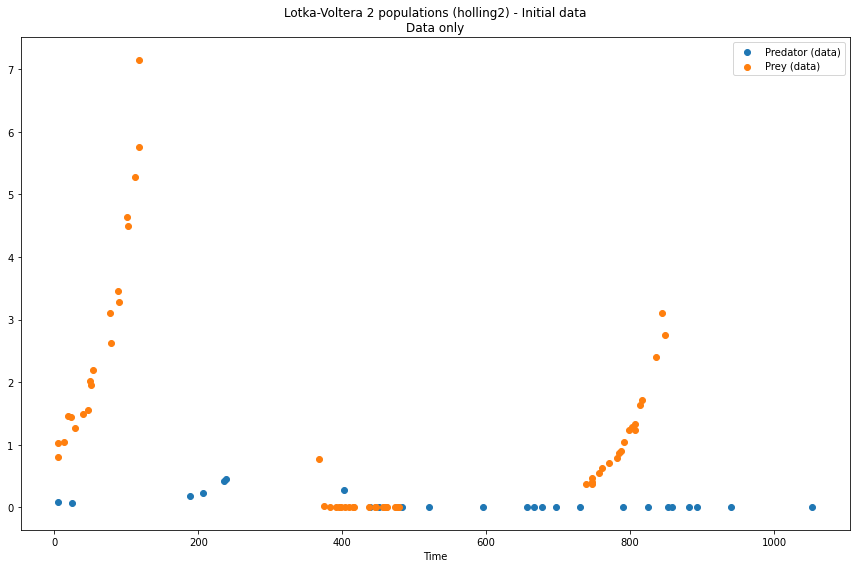

In [98]:
# Data generation
datagen = dg.data_generator(lv_model_2pop_derivatives_basic, eco_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                model_name=f"Lotka-Voltera 2 populations ({eco_params_2pop['func_resp']})")
if common_sample_plan_unif:
    sample_plan = sp.sample_plan(tmax=t_max, nbpoint=nb_points_predator, plan_type="uniform")
else:
    sample_plan = [sp.sample_plan(tmax=t_max, nbpoint=nb_points_predator, plan_type="random"), # predator
                   sp.sample_plan(tmax=t_max, nbpoint=nb_points_prey, plan_type="batch_random",
                                  batch_params={"nbr_batch": nb_years, "ratio_in_out_batch": ratio_in_out_batch})] # prey
# sample_plan = sp.sample_plan(tmax=t_max, nbpoint=20, plan_type="uniform")
plt.figure(figsize=(12, 8))
datagen.get_data(plan=sample_plan, noise_intensity=data_noise_intensity, noise_seed=noise_seed, 
                 plot_data=True, permissible_range=[0, np.inf], default_value=0)
plt.tight_layout()
plt.savefig(path_for_export + "-Data-2_datagen.jpg")
plt.show()
print("* * * * Sampled data * * * *")
print("Number of points (predator-prey):", len(datagen.t_samples[0]), "-", len(datagen.t_samples[1]))
print("Noise intensity:", data_noise_intensity)
plt.figure(figsize=(12, 8))
datagen.plot_initial_data(elements_to_plot=["data"], title=datagen.model_name+" - Initial data"+"\nData only")
plt.tight_layout()
plt.savefig(path_for_export + "-Data-3_datagen_data_only.jpg")
plt.show()

# Export du datagen
with open(path_for_export+"-Data-2_datagen_object.pkl", 'wb') as f:
    pickle.dump(datagen, f)

In [6]:
params_fixed = {key: value for key, value in eco_params_2pop.items() if key not in fitted_params}
params_init = {**params_fitted_init, **params_fixed}


# Display the parameters
from tabulate import tabulate
table = []
for key in eco_params_2pop.keys():
    real_value = eco_params_2pop.get(key, "-")
    initial_value = params_fitted_init.get(key, "-")
    table.append([key, "{:.3f}".format(real_value) if isinstance(real_value, float) else real_value, 
                  "{:.3f}".format(initial_value) if isinstance(initial_value, float) else initial_value])
print(tabulate(table, headers=["Parameter", "Real Value", "Initial Fitted Value"], tablefmt="grid"))


+-------------+--------------+------------------------+
| Parameter   | Real Value   | Initial Fitted Value   |
+=============+==============+========================+
| a1          | 0.088        | 0.100                  |
+-------------+--------------+------------------------+
| a2          | 0.020        | 0.010                  |
+-------------+--------------+------------------------+
| e           | 1            | -                      |
+-------------+--------------+------------------------+
| c           | 0.960        | -                      |
+-------------+--------------+------------------------+
| K           | 0.034        | 0.030                  |
+-------------+--------------+------------------------+
| S           | 0.120        | -                      |
+-------------+--------------+------------------------+
| func_resp   | holling1_sat | -                      |
+-------------+--------------+------------------------+
| a           | 0.086        | 0.100            

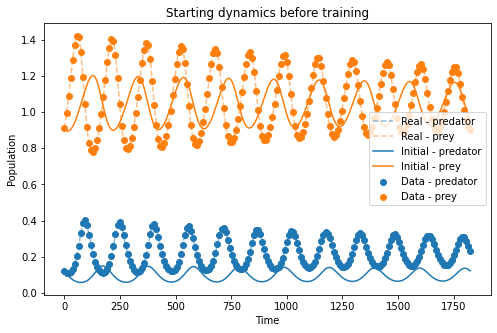

In [7]:
# Plot the initial dynamics
t_simu_adapt = np.linspace(0, t_max, 500)
X_simu_real = odeint(lv_model_2pop_derivatives_basic, X_ini, t_simu_adapt, args=(eco_params_2pop, ), atol=1e-8, rtol=1e-11)
X_simu_init = odeint(lv_model_2pop_derivatives_basic, X_ini, t_simu_adapt, args=(params_init, ), atol=1e-8, rtol=1e-11)



defaut_color = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(8, 5))
plt.plot(t_simu_adapt, X_simu_real[:, 0], label="Real - predator", color=defaut_color[0], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_real[:, 1], label="Real - prey", color=defaut_color[1], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_init[:, 0], label="Initial - predator", color=defaut_color[0])
plt.plot(t_simu_adapt, X_simu_init[:, 1], label="Initial - prey", color=defaut_color[1])
plt.scatter(datagen.t_samples[0], datagen.states_data_noisy[0], color=defaut_color[0], label="Data - predator")
plt.scatter(datagen.t_samples[1], datagen.states_data_noisy[1], color=defaut_color[1], label="Data - prey")
plt.xlabel("Time") ; plt.ylabel("Population")
plt.title("Starting dynamics before training")
plt.legend()
plt.savefig(path_for_export + "-Data-4_initial_guess.jpg")
plt.show()

# PINN

In [8]:
# Adjust the PINN
model_pinn = pinn(lv_model_2pop_derivatives_basic, datagen, params_fitted_init, params_fixed)
model_pinn.get_train_data()
model_pinn.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                               weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-PINN-01_loss_hist_train.dat")

- - - - Train the PINN - - - -
Fitted parameters:  a1 ; a2 ; K ; a
Fixed parameters:  e ; c ; S ; func_resp
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.097520 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.090912 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.10e+01, 8.40e+02, 7.20e-03, 4.14e-01, 1.06e+05, 2.65e+04]    [1.10e+01, 8.40e+02, 7.20e-03, 4.14e-01, 1.06e+05, 2.65e+04]    []  
1000      [1.10e-05, 1.39e-03, 1.55e-09, 7.01e-09, 5.59e-02, 2.72e-01]    [1.10e-05, 1.39e-03, 1.55e-09, 7.01e-09, 5.59e-02, 2.72e-01]    []  
2000      [4.97e-06, 1.26e-03, 1.27e-07, 3.36e-06, 5.29e-02, 2.64e-01]    [4.97e-06, 1.26e-03, 1.27e-07, 3.36e-06, 5.29e-02, 2.64e-01]    []  
3000      [2.22e-04, 1.02e-02, 4.18e-10, 1.64e-08, 5.31e-02, 2.56e-01]    [2.22e-04, 1.02e-02, 4.18e-10, 1.64e-08, 5.31e-02, 2.56e-01]    []  
4000      [1.86e-04, 7.83e-03, 1.03e-12, 7.35e-09, 5.63e-02, 2.45e-01]    [1.86e-04, 7.83e-03, 1.03e-12, 7.35e-09, 5.63e-02, 2.45e-01]    []  
5000      [2.30e-04, 3.33e-03, 3.22e-10, 1.16e-09, 5.23e-02, 2.47e-01]    [2.30e-04, 3.33

CSV file 'outputs/LV2_study_case/holling1_sat-20240309_205428\out-PINN-04_param_values.csv' has been created successfully.
Performance of the model: {'True parameters fixed:': {'e': 1, 'c': 0.96, 'S': 0.12, 'func_resp': 'holling1_sat'}, 'True parameters fitted:': {'a1': 0.088, 'a2': 0.02, 'K': 0.034, 'a': 0.086}, 'Initial fitted parameters:': {'a1': 0.1, 'a2': 0.01, 'K': 0.03, 'a': 0.1}, 'Final fitted parameters:': {'a1': 0.0288, 'a2': -0.0284, 'K': -0.00036, 'a': 0.00651}, 'Training time (in sec):': 5478.2556693553925, 'MSE data-prediction NN:': 0.014411576705125235, 'MSE data-prediction model with fitted parameters:': 0.5986298451893954, 'MSE true model-prediction NN:': 0.014454199934350202, 'MSE true model-prediction model with fitted parameters:': 0.6005128490236407}


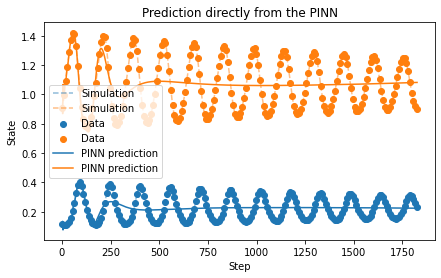

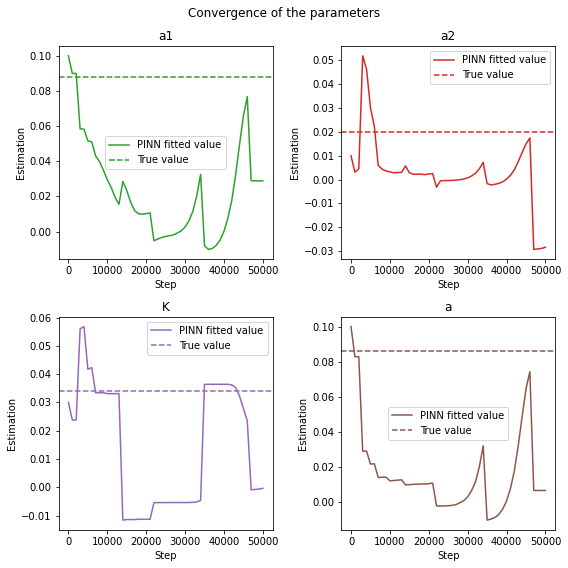

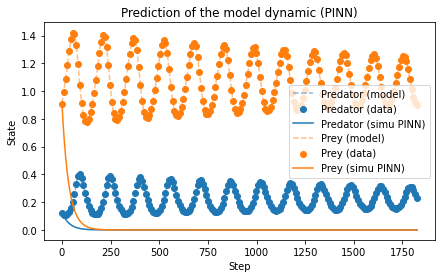

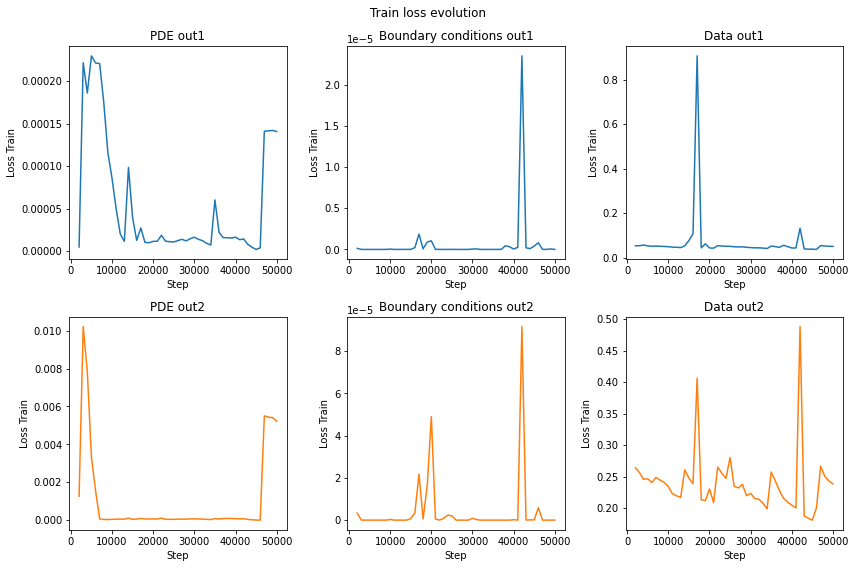

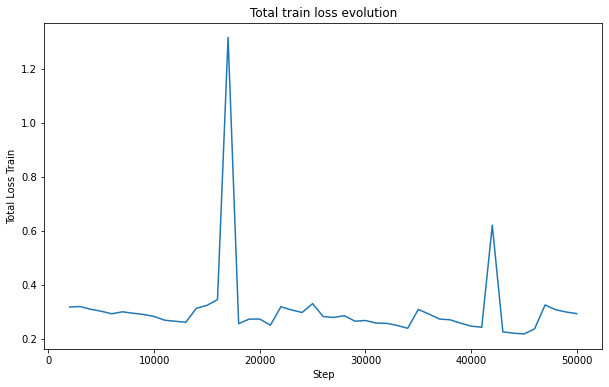

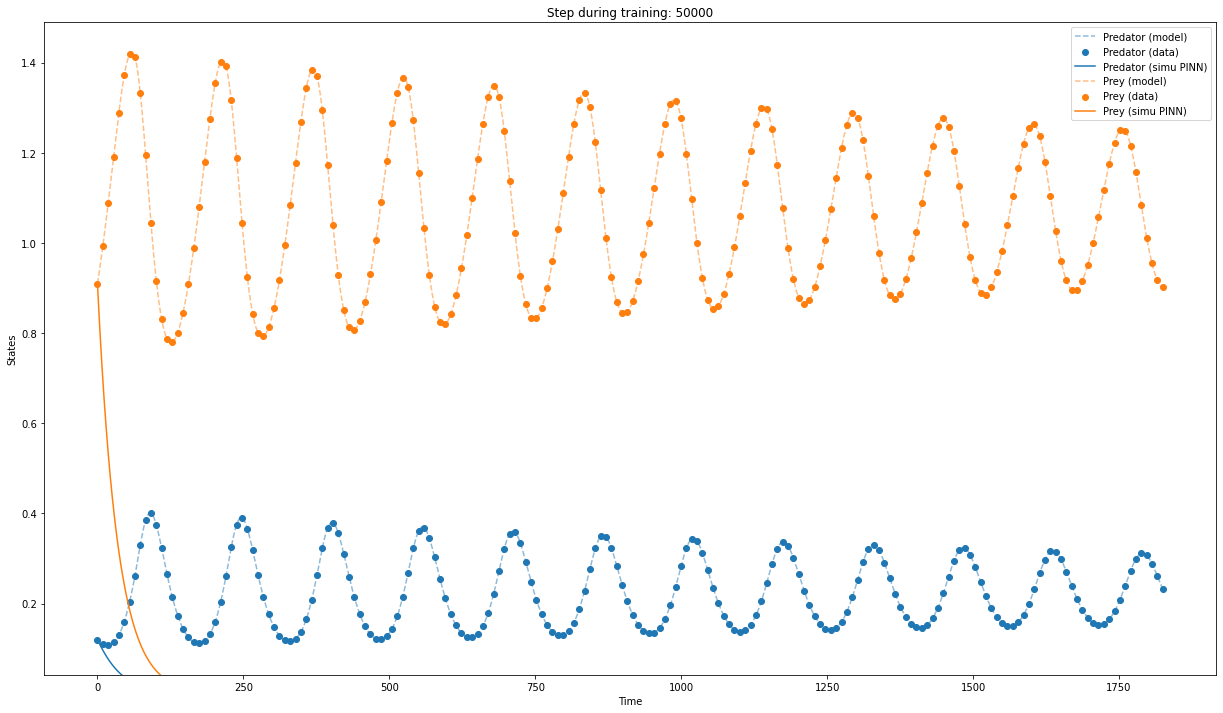

In [9]:
# Plot the training
model_pinn.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, 
                          file_save_fig=path_for_export+"-PINN-05_prediction_PINN.jpg")
model_pinn.plot_convergence(file_save_fig=path_for_export+"-PINN-03_param_convergence.jpg")
model_pinn.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                      file_save_fig=path_for_export+"-PINN-06_prediction_with_params.jpg", nb_p_t=10000)
model_pinn.plot_loss_history(file_save_fig=path_for_export+"-PINN-02_loss_history.jpg", elements_to_plot=["loss_train"], 
                                 start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                               file_save_gif=path_for_export+'-PINN-07_gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)
perf = model_pinn.performance(file_save_params=path_for_export+'-PINN-04_param_values.csv')
with open(path_for_export+"-PINN-09_performances.pkl", 'wb') as f:
    pickle.dump(perf, f)
print("Performance of the model:", perf)
model_pinn.save_possible_attr(filename_save=path_for_export+"-PINN-08_model_data.pkl")

# Scipy

We will use the same t_samples for all states for the curve_fit method
Prediction with curve_fit method (common t_samples)
CSV file 'outputs/LV2_study_case/holling1_sat-20240309_205428\out-Scipy-1_param_values.csv' has been created successfully.
Performance of the model: None


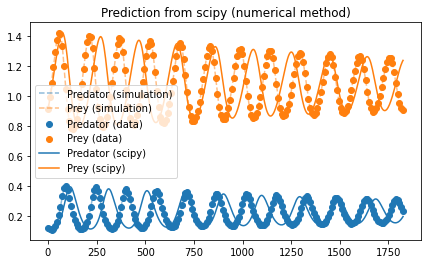

In [10]:
scipy_solver = sf.scipy_fitting(lv_model_2pop_derivatives_basic, datagen)
scipy_solver.get_train_data(new_gen_data=False, permissible_range=[0, np.inf], default_value=0)
t_rebuild, state_rebuild = scipy_solver.predict(params0=params_fitted_init, X_0=X_ini, fixed_params=params_fixed)

scipy_solver.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, 
                        file_save_fig=path_for_export+"-Scipy-2_prediction.jpg")

scipy_perf = scipy_solver.performance(file_save_params=path_for_export+'-Scipy-1_param_values.csv')
print("Performance of the model:", scipy_perf)
with open(path_for_export + "-Scipy-3_performances.pkl", 'wb') as f:
    pickle.dump(scipy_perf, f)